In [1]:
#⚠ Current Business Challenges
#Despite stable logistics costs, the company has experienced deteriorating operational performance:

#📈 The number of delivery delays has increased
#⏳ Average Lead Time has increased
#📉 Service Level (OTD - On-Time Delivery) has begun to decline

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#1 STEP#
#The first step is to load the tables and normalization of data for analysis#

orders = pd.read_excel('Supply_Chain_January_2025.xlsx', sheet_name='Orders_Fact')
costs = pd.read_excel('Supply_Chain_January_2025.xlsx', sheet_name='Monthly_Fixed_Costs')

costs['temp_date'] = pd.to_datetime(dict(year=costs['Year'], month=costs['Month'], day=1))
costs['month'] = costs['temp_date'].dt.to_period('M')
costs = costs.drop(columns=['temp_date'])
costs

,Year,Month,Cost_Type,Amount,month
0,2025,1,Warehouse Rent,25000,2025-01
1,2025,1,IT Systems,6000,2025-01
2,2025,1,Admin Salaries,18000,2025-01
3,2025,1,Marketing,9000,2025-01


In [29]:
orders['Order_Date'] = pd.to_datetime(orders['Order_Date'])
orders['Promised_Date'] = pd.to_datetime(orders['Promised_Date'])
orders['Actual_Delivery_Date'] = pd.to_datetime(orders['Actual_Delivery_Date'])
orders['month'] = orders['Order_Date'].dt.to_period('M')

orders.head(5)

,Order_ID,Order_Date,Promised_Date,Actual_Delivery_Date,Customer_Type,Country,Warehouse,Route_ID,SKU,Category,Sold_Qty,Price_per_Unit,COGS_per_Unit,Logistics_Cost_per_Unit,Discount_%,month
0,ORD_00001,2025-01-18,2025-01-21,2025-01-20,B2B,HU,WH_B,R02,SKU_H1,Home,7,84.32,38.75,10.57,15,2025-01
1,ORD_00002,2025-01-30,2025-02-01,2025-02-02,Retail,HU,WH_A,R01,SKU_O1,Office,7,105.22,58.08,9.15,5,2025-01
2,ORD_00003,2025-01-10,2025-01-14,2025-01-14,Retail,HU,WH_B,R02,SKU_O2,Office,4,23.58,14.61,3.33,15,2025-01
3,ORD_00004,2025-01-14,2025-01-16,2025-01-16,Retail,HU,WH_B,R01,SKU_H1,Home,14,38.56,16.60,8.79,15,2025-01
4,ORD_00005,2025-01-01,2025-01-05,2025-01-05,B2B,SK,WH_B,R04,SKU_E3,Electronics,14,29.67,13.73,6.91,15,2025-01


In [30]:
#2 STEP# 
#Let's check whether the dataset has outliers, empty rows, or anomalies.#

orders.duplicated().sum()

0

In [31]:
orders.isna().sum()

Order_ID                   0
Order_Date                 0
Promised_Date              0
Actual_Delivery_Date       0
Customer_Type              0
Country                    0
Warehouse                  0
Route_ID                   0
SKU                        0
Category                   0
Sold_Qty                   0
Price_per_Unit             0
COGS_per_Unit              0
Logistics_Cost_per_Unit    0
Discount_%                 0
month                      0
dtype: int64

In [32]:
orders.describe()

,Order_Date,Promised_Date,Actual_Delivery_Date,Sold_Qty,Price_per_Unit,COGS_per_Unit,Logistics_Cost_per_Unit,Discount_%
count,2200,2200,2200,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,2025-01-15 23:35:46.909091072,2025-01-18 23:46:54.545454592,2025-01-18 23:24:39.272727296,10.385909,110.437114,58.106123,7.488127,7.297727
min,2025-01-01 00:00:00,2025-01-03 00:00:00,2025-01-02 00:00:00,1.000000,20.140000,8.210000,3.010000,0.000000
25%,2025-01-08 00:00:00,2025-01-11 00:00:00,2025-01-11 00:00:00,5.000000,66.735000,33.740000,5.157500,0.000000
50%,2025-01-16 00:00:00,2025-01-19 00:00:00,2025-01-19 00:00:00,10.000000,112.020000,57.265000,7.570000,5.000000
75%,2025-01-24 00:00:00,2025-01-27 00:00:00,2025-01-27 00:00:00,15.000000,154.920000,79.807500,9.700000,10.000000
max,2025-01-31 00:00:00,2025-02-04 00:00:00,2025-02-07 00:00:00,20.000000,199.950000,127.250000,11.990000,15.000000
std,NaN,NaN,NaN,5.757308,51.899861,28.711286,2.601753,5.557177


In [33]:
# 3 STEP #
# It is necessary to calculate metrics for further analysis #

orders['Lead Time'] = (orders['Actual_Delivery_Date'] - orders['Order_Date']).dt.days
orders['Delayed'] = (orders['Actual_Delivery_Date'] - orders['Promised_Date']).dt.days
orders['Promised_Lead_Time'] = (orders['Promised_Date'] - orders['Order_Date']).dt.days
orders['In_Time'] = 0
orders.loc[orders['Delayed'] <= 0, 'In_Time'] = 1

orders['Net_Price_per_Unit'] = orders['Price_per_Unit'] * (1-(orders['Discount_%'])*0.01)
orders['Revenue'] = orders['Net_Price_per_Unit']*orders['Sold_Qty']
orders['Gross profit'] = orders['Revenue'] - (orders['COGS_per_Unit']*orders['Sold_Qty'])

#To accurately calculate Net Profit, a two-level data model is used:
#Table 1 — Orders
#Table 2 — Costs
#Since the second table aggregates costs at the monthly (not order) level, I will use the uniform distribution method.

costs_in_january = costs.groupby('month')['Amount'].sum().reset_index(name='total_costs')
total_orders_in_january = orders.groupby('month')['Order_ID'].count().reset_index(name='total_orders')

result = total_orders_in_january.merge(costs_in_january)
result['Extra_costs_per_order'] = result['total_costs']/result['total_orders']
result = result[['month', 'Extra_costs_per_order']]

orders = orders.merge(result)
orders['Net_profit'] = orders['Gross profit'] - (orders['Extra_costs_per_order'] + (orders['Logistics_Cost_per_Unit']*orders['Sold_Qty']))
orders

,Order_ID,Order_Date,Promised_Date,Actual_Delivery_Date,Customer_Type,Country,Warehouse,Route_ID,SKU,Category,...,month,Lead Time,Delayed,Promised_Lead_Time,In_Time,Net_Price_per_Unit,Revenue,Gross profit,Extra_costs_per_order,Net_profit
0,ORD_00001,2025-01-18,2025-01-21,2025-01-20,B2B,HU,WH_B,R02,SKU_H1,Home,...,2025-01,2,-1,3,1,71.6720,501.704,230.454,26.363636,130.100364
1,ORD_00002,2025-01-30,2025-02-01,2025-02-02,Retail,HU,WH_A,R01,SKU_O1,Office,...,2025-01,3,1,2,0,99.9590,699.713,293.153,26.363636,202.739364
2,ORD_00003,2025-01-10,2025-01-14,2025-01-14,Retail,HU,WH_B,R02,SKU_O2,Office,...,2025-01,4,0,4,1,20.0430,80.172,21.732,26.363636,-17.951636
3,ORD_00004,2025-01-14,2025-01-16,2025-01-16,Retail,HU,WH_B,R01,SKU_H1,Home,...,2025-01,2,0,2,1,32.7760,458.864,226.464,26.363636,77.040364
4,ORD_00005,2025-01-01,2025-01-05,2025-01-05,B2B,SK,WH_B,R04,SKU_E3,Electronics,...,2025-01,4,0,4,1,25.2195,353.073,160.853,26.363636,37.749364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,ORD_02196,2025-01-26,2025-01-28,2025-01-29,B2B,HU,WH_A,R03,SKU_E2,Electronics,...,2025-01,3,1,2,0,41.6385,666.216,315.656,26.363636,206.252364
2196,ORD_02197,2025-01-04,2025-01-08,2025-01-07,Retail,HU,WH_B,R01,SKU_H2,Home,...,2025-01,3,-1,4,1,134.9010,1214.109,568.629,26.363636,449.925364
2197,ORD_02198,2025-01-15,2025-01-19,2025-01-18,Retail,PL,WH_A,R04,SKU_O2,Office,...,2025-01,3,-1,4,1,123.2460,2341.674,1123.394,26.363636,915.580364
2198,ORD_02199,2025-01-28,2025-01-31,2025-01-31,Retail,CZ,WH_A,R01,SKU_E3,Electronics,...,2025-01,3,0,3,1,20.1700,121.020,57.960,26.363636,10.776364


In [34]:
# 4 STEP #
#Before starting the analysis, let's see if there are any unprofitable orders in the dataset based on Net Profit #

def Profit_flag(arg):
    if arg < 0:
        return 'Critically low profitability'
    elif arg < 50:
        return 'Low profit'
    elif arg < 500:
        return 'Stability profit'
    else:
        return 'Perfect profit'

orders['Profit_flag'] = orders['Net_profit'].apply(Profit_flag)
orders.groupby('Profit_flag').size()

# The initial analysis revealed that 20% of orders generated negative net profit.
# This indicator is a significant deviation and may indicate structural problems in unit economics, pricing, or cost allocation.
# However, at this stage, the priority of the analysis has shifted to the operational issue—the decline in Service Level (SLA/OTD), so I'll focus on that for now.

Profit_flag
Critically low profitability     150
Low profit                       289
Perfect profit                   593
Stability profit                1168
dtype: int64

In [35]:
red_orders = orders[(orders['Profit_flag'] == 'Critically low profitability')|(orders['Profit_flag'] == 'Low profit')]
red_orders.head(5)
#For the future, I will prepare a dataset with unprofitable orders.

,Order_ID,Order_Date,Promised_Date,Actual_Delivery_Date,Customer_Type,Country,Warehouse,Route_ID,SKU,Category,...,Lead Time,Delayed,Promised_Lead_Time,In_Time,Net_Price_per_Unit,Revenue,Gross profit,Extra_costs_per_order,Net_profit,Profit_flag
2,ORD_00003,2025-01-10,2025-01-14,2025-01-14,Retail,HU,WH_B,R02,SKU_O2,Office,...,4,0,4,1,20.0430,80.1720,21.7320,26.363636,-17.951636,Critically low profitability
4,ORD_00005,2025-01-01,2025-01-05,2025-01-05,B2B,SK,WH_B,R04,SKU_E3,Electronics,...,4,0,4,1,25.2195,353.0730,160.8530,26.363636,37.749364,Low profit
6,ORD_00007,2025-01-04,2025-01-08,2025-01-08,B2B,HU,WH_A,R03,SKU_E3,Electronics,...,4,0,4,1,31.5180,472.7700,184.1700,26.363636,43.206364,Low profit
7,ORD_00008,2025-01-30,2025-02-02,2025-02-04,Retail,CZ,WH_B,R04,SKU_H2,Home,...,5,2,3,0,127.6105,127.6105,66.6905,26.363636,34.586864,Low profit
8,ORD_00009,2025-01-19,2025-01-23,2025-01-24,Retail,SK,WH_A,R01,SKU_H2,Home,...,5,1,4,0,30.7900,123.1600,72.8400,26.363636,15.596364,Low profit


                          Order_Date                  Promised_Date  \
count                           2200                           2200   
mean   2025-01-15 23:35:46.909091072  2025-01-18 23:46:54.545454592   
min              2025-01-01 00:00:00            2025-01-03 00:00:00   
25%              2025-01-08 00:00:00            2025-01-11 00:00:00   
50%              2025-01-16 00:00:00            2025-01-19 00:00:00   
75%              2025-01-24 00:00:00            2025-01-27 00:00:00   
max              2025-01-31 00:00:00            2025-02-04 00:00:00   
std                              NaN                            NaN   

                Actual_Delivery_Date     Sold_Qty  Price_per_Unit  \
count                           2200  2200.000000     2200.000000   
mean   2025-01-18 23:24:39.272727296    10.385909      110.437114   
min              2025-01-02 00:00:00     1.000000       20.140000   
25%              2025-01-11 00:00:00     5.000000       66.735000   
50%            

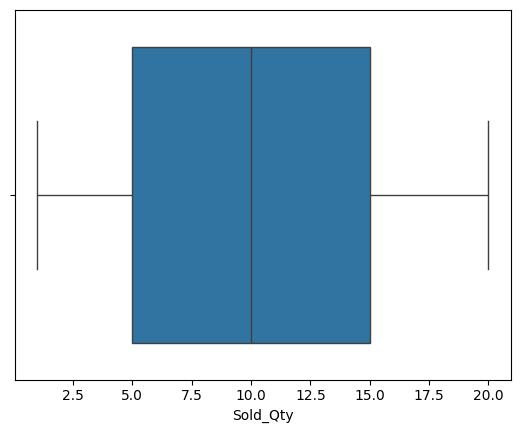

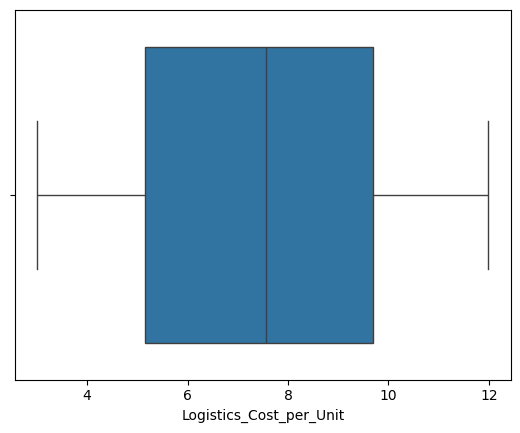

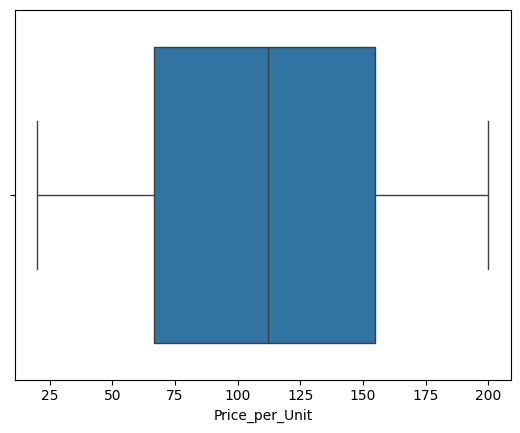

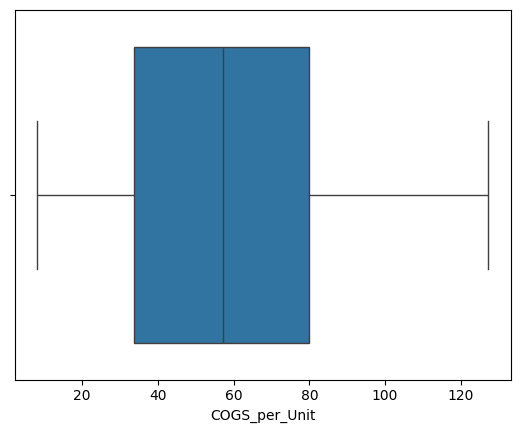

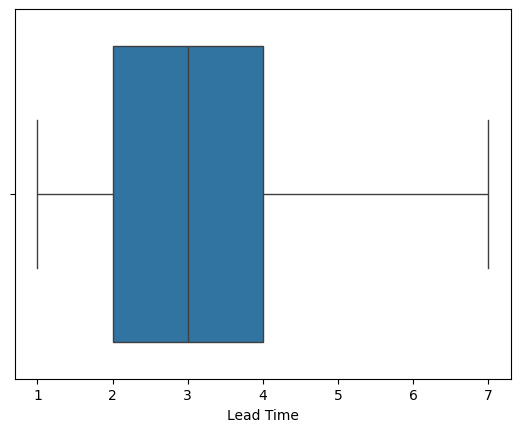

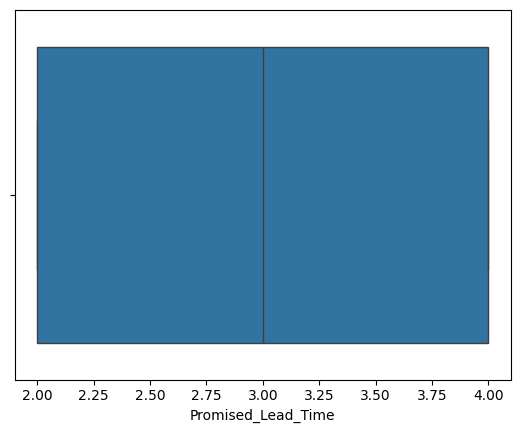

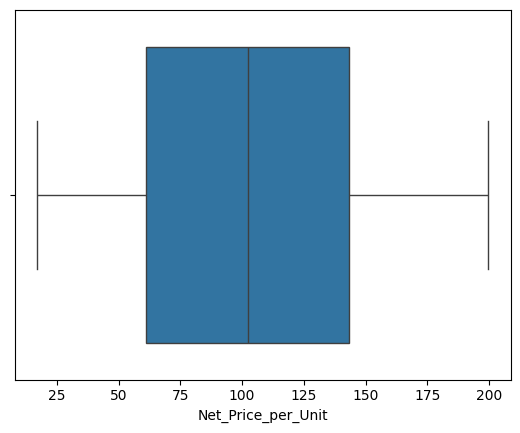

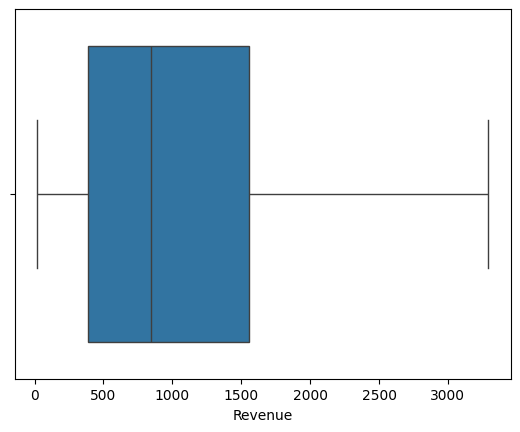

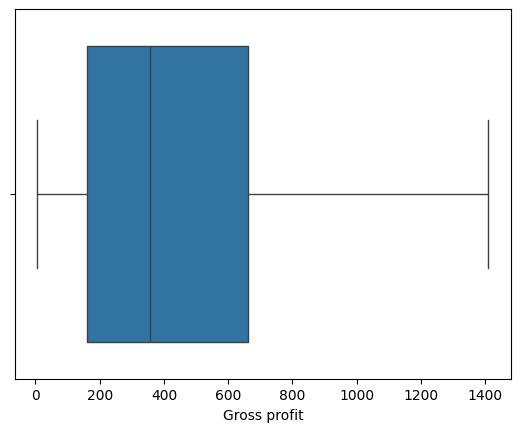

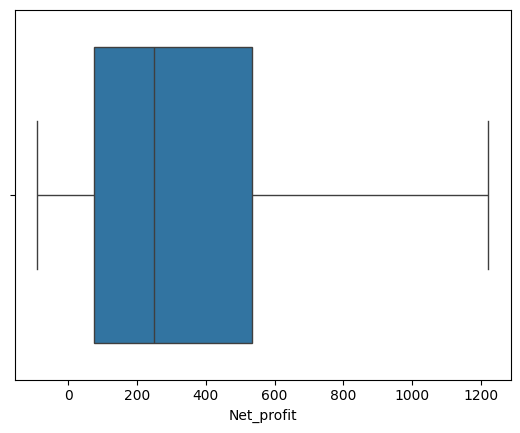

In [36]:
#Emissions Check#

print(orders.describe())


emissions_check_arr = ['Sold_Qty', 'Logistics_Cost_per_Unit', 'Price_per_Unit', 
                       'COGS_per_Unit', 'Lead Time', 'Promised_Lead_Time', 'Net_Price_per_Unit', 'Revenue', 'Gross profit', 'Net_profit']

for i in emissions_check_arr:
    sns.boxplot(x=orders[i], showfliers=False)
    plt.show()

#no emissions observed

In [37]:
# 5 STEP #
#To determine when a problem arises, it is necessary to move from an aggregated monthly analysis to the daily dynamics of key metrics.

#The goal is to identify:
# The period when the degradation of indicators began
# Which metrics began to change first
# Whether the problem was gradual or sudden

orders.groupby('Order_Date')[['Net_profit', 'Sold_Qty', 'Lead Time', 'Delayed']].agg(['mean', 'median'])

#Based on the structural break identified on January 15, 2025, the following hypotheses are developed...
#Hypothesis 1.
#After January 15, 2025, the average actual deviation from the promised delivery date (delay time) increased. This led to an increase in the actual lead time and a mechanical decrease in the OTD metric, which collectively led to a deterioration in the overall service level agreement (SLA).

#Hypothesis 2.
#The increase in delays is uneven: a small proportion of operational combinations +- 20% (Route + WH + Country + Category) contributes disproportionately to the increase in lead time after January 15 (~80%).
#(In other words, the problem may be localized rather than systemic, and concentrated in specific segments of the operational chain.)

#Hypothesis 3.
#The deterioration in SLA is associated with an external or structural change in the process after January 15, 2025 (e.g., a change in transport contractor, a change in routing, a redistribution of workload between warehouses, or a change in cut-off times).

Net_profit               Sold_Qty        Lead Time         \
                  mean      median       mean median      mean median   
Order_Date                                                              
2025-01-01  326.825489  157.843114   9.838235    9.0  2.544118    3.0   
2025-01-02  364.385394  284.564364  10.276923   11.0  2.338462    2.0   
2025-01-03  309.704119  183.612614  10.272727   10.0  2.431818    2.0   
2025-01-04  347.898055  190.218864  10.136986   10.0  2.438356    2.0   
2025-01-05  371.365829  289.311364  10.180556   10.0  2.444444    2.0   
2025-01-06  407.497697  336.036364  10.853333   10.0  2.760000    3.0   
2025-01-07  441.082254  307.567614  11.939024   12.0  2.634146    3.0   
2025-01-08  270.060817  180.836364   8.661538    7.0  2.446154    2.0   
2025-01-09  375.009625  350.919864  11.149254   12.0  2.701493    3.0   
2025-01-10  395.472186  340.449864  11.016129   11.5  2.370968    2.0   
2025-01-11  421.540536  338.136364  11.327869   12.0  2.557377    2.0   
2025-01-12  382.320070  262.236364  10.571429   10.0  2.269841    2.0   
2025-01-13  306.813606  183.870114  10.294118   10.5  2.455882    2.0   
2025-01-14  396.518949  331.172864  11.210526   11.0  2.657895    3.0   
2025-01-15  322.780815  202.707614   9.888889    8.5  2.527778    3.0   
2025-01-16  291.332808  127.276364   9.682540    9.0  3.253968    3.0   
2025-01-17  357.884246  236.980364   9.800000    9.0  3.600000    3.0   
2025-01-18  394.204075  250.875364  10.450704   11.0  3.760563    4.0   
2025-01-19  358.142971  293.571364  10.885714   11.0  3.200000    3.0   
2025-01-20  297.039914  233.616864   9.500000    9.5  3.816667    4.0   
2025-01-21  327.074681  242.213864  11.067568   14.0  3.472973    3.0   
2025-01-22  333.052790  248.908364  10.049383   10.0  3.283951    3.0   
2025-01-23  363.820916  255.096364  10.238806   10.0  2.761194    3.0   
2025-01-24  362.549343  282.140364  10.643836   11.0  3.301370    3.0   
2025-01-25  240.207474  130.936364   7.727273    7.0  3.454545    3.0   
2025-01-26  361.798138  290.158864   9.794521    9.0  2.958904    3.0   
2025-01-27  395.152892  370.536364  11.577465   13.0  3.563380    3.0   
2025-01-28  333.813579  247.588864  10.177215   10.0  4.063291    4.0   
2025-01-29  334.108605  245.651364  10.066667    8.0  3.583333    3.0   
2025-01-30  338.592926  237.390114  10.234375   10.0  3.406250    3.0   
2025-01-31  428.631430  349.616364  12.266667   12.0  3.480000    3.0   

             Delayed         
                mean median  
Order_Date                   
2025-01-01 -0.529412   -1.0  
2025-01-02 -0.476923    0.0  
2025-01-03 -0.534091   -1.0  
2025-01-04 -0.520548   -1.0  
2025-01-05 -0.472222    0.0  
2025-01-06 -0.453333    0.0  
2025-01-07 -0.439024    0.0  
2025-01-08 -0.476923    0.0  
2025-01-09 -0.402985    0.0  
2025-01-10 -0.548387   -1.0  
2025-01-11 -0.442623    0.0  
2025-01-12 -0.603175   -1.0  
2025-01-13 -0.544118   -1.0  
2025-01-14 -0.407895    0.0  
2025-01-15 -0.555556   -1.0  
2025-01-16  0.238095    0.0  
2025-01-17  0.447059    0.0  
2025-01-18  0.676056    0.0  
2025-01-19  0.242857    0.0  
2025-01-20  0.833333    1.0  
2025-01-21  0.364865    0.0  
2025-01-22  0.333333    0.0  
2025-01-23 -0.179104   -1.0  
2025-01-24  0.260274    0.0  
2025-01-25  0.467532    0.0  
2025-01-26  0.232877    0.0  
2025-01-27  0.563380    0.0  
2025-01-28  0.949367    1.0  
2025-01-29  0.450000    0.0  
2025-01-30  0.453125    0.0  
2025-01-31  0.453333    0.0

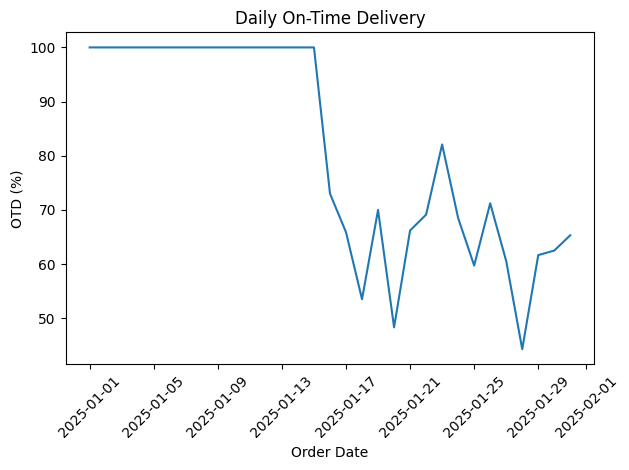

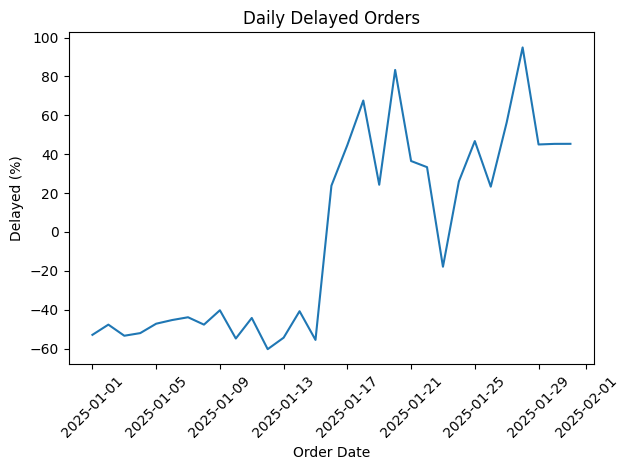

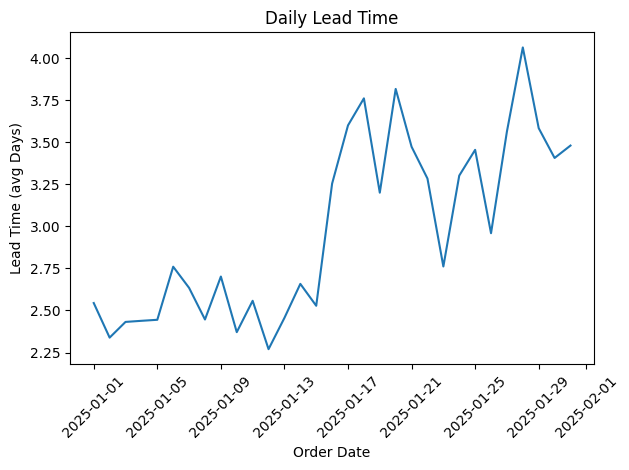

In [57]:
# 6 STEP #
#I will check the first hypothesis and calculate the OTD.

otd_daily = orders.groupby('Order_Date')['In_Time'].mean().mul(100).reset_index(name='OTD_%')

plt.plot(otd_daily['Order_Date'], otd_daily['OTD_%']) 
plt.xlabel("Order Date") 
plt.ylabel("OTD (%)") 
plt.title("Daily On-Time Delivery") 
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

###########################
delayed_daily = orders.groupby('Order_Date')['Delayed'].mean().mul(100).reset_index(name='delayed_orders')

plt.plot(delayed_daily['Order_Date'], delayed_daily['delayed_orders']) 
plt.xlabel("Order Date") 
plt.ylabel("Delayed (%)") 
plt.title("Daily Delayed Orders") 
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()
###########################
leadTime_daily = orders.groupby('Order_Date')['Lead Time'].mean().reset_index()

plt.plot(leadTime_daily['Order_Date'], leadTime_daily['Lead Time']) 
plt.xlabel("Order Date") 
plt.ylabel("Lead Time (avg Days)") 
plt.title("Daily Lead Time") 
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

#The data points to a structural break on January 15, 2025, followed by a sharp decline in OTD and an increase in Delayed Orders.
#Hypothesis 1 is confirmed.
#To conduct a deeper and more accurate analysis, the dataset should be divided into two distinct periods: before and after January 15.

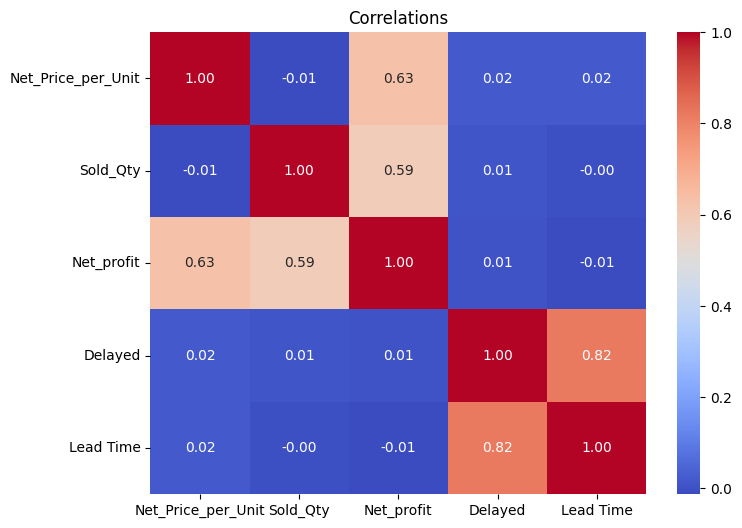

In [60]:
##We will also confirm through correlation analysis that long lead times are associated with increased delays##
corr_matrix = orders.corr(numeric_only=True)
corr_matrix = orders[['Net_Price_per_Unit','Sold_Qty','Net_profit', 'Delayed', 'Lead Time']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',  
    fmt=".2f"
)

plt.title("Correlations")
plt.show()

#We see a strong correlation between Lead Time and delays, and therefore we are once again convinced of the truth of hypothesis 1.
#There is also a correlation between Net_price _per _unit, Sold _Qty and Net_profit. Let's take this into account in the next part of the analysis.

In [61]:
# 7 STEP #
# I divide the data into 2 groups: Before the 15th and After #

before_problem = orders[orders['Actual_Delivery_Date'] <= '2025-01-15']
after_problem = orders[orders['Actual_Delivery_Date'] > '2025-01-15']

In [62]:
from scipy.stats import mannwhitneyu
mannwhitneyu(before_problem['Lead Time'], after_problem['Lead Time'])

#A Mann–Whitney U test was conducted to compare Lead Time distributions before and after January 15.
#The result was statistically significant (p < 0.001), confirming a structural shift in operational performance.

MannwhitneyuResult(statistic=384681.0, pvalue=5.08371566779188e-43)

In [63]:
# 8 STEP #
#To evaluate the potential financial impact of the operational shift, we will compare key metrics before and after January 15, examining whether the increase in Lead Time translated into changes in revenue or net profit.

print(before_problem[['Revenue', 'Gross profit', 'Sold_Qty', 'Net_profit', 'Lead Time']].median())
print('    ')
print(after_problem[['Revenue', 'Gross profit', 'Sold_Qty', 'Net_profit', 'Lead Time']].median())

# Following the increase in Lead Time, financial metrics (Revenue and Net Profit) showed no significant changes. This suggests that the operational deterioration has not yet resulted in a direct financial impact and that the problem is primarily process-related.
#Next, it would be appropriate to test the second hypothesis and focus on analyzing the operational combinations (Route + Warehouse + Country + Category) that may have contributed disproportionately to the increase in Lead Time after January 15.

Revenue         870.912000
Gross profit    360.958500
Sold_Qty         11.000000
Net_profit      249.823864
Lead Time         2.000000
dtype: float64
    
Revenue         838.860000
Gross profit    349.380000
Sold_Qty         10.000000
Net_profit      248.516364
Lead Time         3.000000
dtype: float64


In [64]:
# 9 STEP #
# For a more detailed analysis, a sample of 50 random transaction combinations will be generated for each period (before and after January 15). 
#For each combination, the dynamics of lead time and delay levels will be assessed.

print(before_problem.groupby(['Country', 'Warehouse', 'Route_ID', 'Category'])[['Lead Time', 'Delayed']].mean().reset_index().sample(50)) #LT is stable in 2-3 days, no delays, even all combinations are delivered ahead of schedule.
print('')
print('')
print(after_problem.groupby(['Country', 'Warehouse', 'Route_ID', 'Category'])[['Lead Time', 'Delayed']].mean().reset_index().sample(50)) #The increase in Lead Time affected almost all combinations.

   Country Warehouse Route_ID     Category  Lead Time   Delayed
49      PL      WH_A      R01         Home   2.166667 -0.833333
17      CZ      WH_B      R02       Office   2.833333 -0.166667
18      CZ      WH_B      R03  Electronics   2.125000 -0.750000
85      SK      WH_B      R01         Home   3.333333  0.000000
74      SK      WH_A      R01       Office   2.916667 -0.166667
48      PL      WH_A      R01  Electronics   2.750000 -0.125000
32      HU      WH_A      R03       Office   2.600000 -0.466667
2       CZ      WH_A      R01       Office   2.333333 -0.333333
37      HU      WH_B      R01         Home   2.666667 -0.600000
5       CZ      WH_A      R02       Office   2.285714 -0.571429
42      HU      WH_B      R03  Electronics   2.923077 -0.461538
12      CZ      WH_B      R01  Electronics   2.230769 -0.692308
44      HU      WH_B      R03       Office   2.428571 -0.428571
4       CZ      WH_A      R02         Home   2.769231 -0.384615
56      PL      WH_A      R03       Offi

In [65]:
# 10 STEP #
# Let’s test Hypothesis 2 in more detail. 
# To do so, we will identify the most problematic operational combinations and analyze their contribution to the total number of late deliveries.

stats = after_problem.groupby(['Country','Warehouse','Route_ID','Category']).agg(
    total_orders=('Order_ID','count'),
    late_orders=('In_Time', lambda x: (x == 0).sum()),
    delay_days_sum=('Delayed', lambda x: x[x > 0].sum())
).reset_index()

stats['late_rate'] = stats['late_orders'] / stats['total_orders'] * 100

stats = stats.sort_values('delay_days_sum', ascending=False).reset_index(drop=True)

stats['cum_delay_share'] = stats['delay_days_sum'].cumsum() / stats['delay_days_sum'].sum() * 100
share_combos = (stats['cum_delay_share'] <= 80).mean() * 100
share_combos



# The analysis shows that delays are widely distributed across 60.4% of operational combinations, suggesting a systemic deterioration rather than isolated bottlenecks.
# Hypothesis 2 was not confirmed. 

60.416666666666664

In [66]:
# 11 STEP #

# Additionally, it's necessary to check whether the median Promised Date has changed since January 15th.
#If the company began setting shorter promised delivery times, the increase in delays could be explained not by a decline in actual operational efficiency, but by a tightening of the SLA. 
#In this case, the increase in delays would be an expected consequence of more aggressive promises to customers.

print(before_problem['Promised_Lead_Time'].median())
print(after_problem['Promised_Lead_Time'].median()) 

#No changes were found in the Promised date.

3.0
3.0


In [67]:
#Conclusion#

#After January 15, 2025, a systemic increase in actual lead time was recorded, accompanied by a decrease in the OTD metric.
#The analysis showed that the deterioration was not concentrated in individual operating segments. Lead time and SLA metrics deteriorated relatively evenly across all Warehouse + Route + Country + Category combinations. No significant local bottleneck was identified.
#Therefore, the problem is systemic and related to a general decline in order fulfillment, rather than an isolated failure in a specific warehouse, route, or category.

In [68]:
# Let's go back to check the losing orders, what is the reason? #
#I'll check how many unprofitable orders there were each day...

red_orders.groupby('Order_Date').size()

#An analysis of the number of unprofitable orders by day in January shows no significant changes in load levels after January 15. 
#The daily volume of unprofitable orders remains within a comparable range both before and after the identified turning point.

Order_Date
2025-01-01    24
2025-01-02    15
2025-01-03    20
2025-01-04    17
2025-01-05    17
2025-01-06    10
2025-01-07    12
2025-01-08    20
2025-01-09    13
2025-01-10    12
2025-01-11     6
2025-01-12    14
2025-01-13    14
2025-01-14    12
2025-01-15    16
2025-01-16    17
2025-01-17    14
2025-01-18    12
2025-01-19    11
2025-01-20    15
2025-01-21    14
2025-01-22    18
2025-01-23    13
2025-01-24    13
2025-01-25    21
2025-01-26    11
2025-01-27     9
2025-01-28    13
2025-01-29    10
2025-01-30    14
2025-01-31    12
dtype: int64

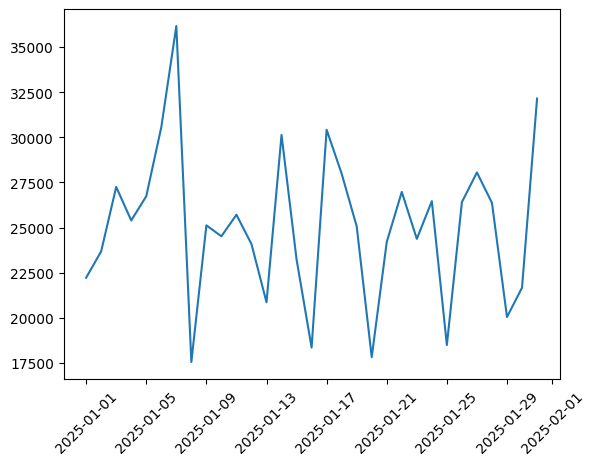

In [69]:
#Let's check if there is a "Tipping Point" when profit becomes especially low.#

daily_profit = (orders.set_index('Order_Date').resample('D')['Net_profit'].sum())

plt.figure()
plt.plot(daily_profit)
plt.xticks(rotation=45)
plt.show() 

#An analysis of profit dynamics reveals a chaotic decline without a clearly defined structural break. 
#It's impossible to pinpoint a specific date after which profits began to systematically decline.

In [70]:
#It's worth checking whether a particular SKU is causing a particularly large share of losses or not#

total_orders_by_sku = orders.groupby('SKU').size().reset_index(name='count_ord')
red_orders_by_sku = red_orders.groupby('SKU').size().reset_index(name='count_red_ord')
SKU_check = total_orders_by_sku.merge(red_orders_by_sku, on='SKU')
SKU_check['Pct_loss_making_profit'] = (SKU_check['count_red_ord']/SKU_check['count_ord'])*100
SKU_check 

#An analysis of profitability by SKU shows that the decline in profit is distributed relatively evenly—no individual products are demonstrating abnormally high negative contributions. 
#There are no significant outliers or SKUs accounting for a disproportionately large share of losses.

,SKU,count_ord,count_red_ord,Pct_loss_making_profit
0,SKU_E1,242,64,26.446281
1,SKU_E2,268,55,20.522388
2,SKU_E3,251,50,19.920319
3,SKU_H1,391,68,17.391304
4,SKU_H2,353,78,22.096317
5,SKU_O1,232,38,16.379310
6,SKU_O2,251,45,17.928287
7,SKU_O3,212,41,19.339623


In [71]:
#The dataset will be divided into two groups—loss-making and profitable orders—and then the average values of key monetary indicators (Sold_Qty, Net_Price_per_Unit, Price_per_Unit, COGS_per_Unit, Discount) will be compared. 
#This will help determine which specific parameters are driving negative profit and whether the loss is related to cost price, discounts, pricing, or sales volume.

analys_redOrd = red_orders.groupby('SKU')[['Net_Price_per_Unit' , 'Price_per_Unit', 'Sold_Qty', 'COGS_per_Unit', 'Revenue', 'Gross profit', 'Logistics_Cost_per_Unit', 'Extra_costs_per_order', 'Net_profit']].median().reset_index()
analys_redOrd['Discount_impcat'] = ((analys_redOrd['Price_per_Unit']-analys_redOrd['Net_Price_per_Unit'])/analys_redOrd['Price_per_Unit'])*100
print(analys_redOrd)
print()
print()
print(orders[(orders['Profit_flag'] == 'Stability profit')|(orders['Profit_flag'] == 'Perfect profit')].groupby('SKU')[['Net_Price_per_Unit' , 'Price_per_Unit', 'Sold_Qty', 'COGS_per_Unit', 'Revenue', 'Gross profit', 'Logistics_Cost_per_Unit', 'Extra_costs_per_order', 'Net_profit']].median().reset_index())

#Low profitability for individual orders is likely due to the high proportion of fixed and logistics costs with an average order volume of 4-6 units, which reduces the efficiency of cost allocation per unit.
#Next, it's advisable to check whether the negative profit is solely due to the low volume of units sold, or whether it is the result of a combination of factors—low selling price and the quantity of goods per order.

      SKU  Net_Price_per_Unit  Price_per_Unit  Sold_Qty  COGS_per_Unit  \
0  SKU_E1            40.77450          47.620       4.0         26.955   
1  SKU_E2            38.37600          42.760       4.0         26.520   
2  SKU_E3            35.65175          40.230       5.0         21.070   
3  SKU_H1            44.25600          49.050       4.0         27.405   
4  SKU_H2            51.96500          55.610       2.5         30.415   
5  SKU_O1            39.02000          44.165       5.0         24.125   
6  SKU_O2            47.32200          52.580       3.0         29.820   
7  SKU_O3            52.32600          60.380       4.0         25.280   

     Revenue  Gross profit  Logistics_Cost_per_Unit  Extra_costs_per_order  \
0  164.73000      64.12650                    7.770              26.363636   
1  199.20600      77.64000                    8.260              26.363636   
2  177.75500      79.41075                    7.865              26.363636   
3  174.85550      65.

In [72]:
orders[['Net_Price_per_Unit', 'Sold_Qty']].corrwith(orders['Net_profit'])

Net_Price_per_Unit    0.630938
Sold_Qty              0.592294
dtype: float64

In [73]:
#I will analyze unprofitable orders with more than 10 units sold to determine whether negative profitability is driven solely by low volume or by other factors#

red_orders[red_orders['Sold_Qty'] > 10][['Net_Price_per_Unit', 'COGS_per_Unit', 'Price_per_Unit', 'Sold_Qty', 'Revenue', 'Gross profit' ,'Net_profit']]

#Analysis shows that unprofitable orders are primarily caused by a combination of low selling prices and medium or high unit volumes. This means that even with sufficient order quantities, negative profits persist.
#Thus, the key driver of unprofitability is the price level (or excessive discounts), not just sales volume. Even with a good order volume, an insufficient markup fails to cover the cost price and allocated expenses.

,Net_Price_per_Unit,COGS_per_Unit,Price_per_Unit,Sold_Qty,Revenue,Gross profit,Net_profit
4,25.2195,13.73,29.67,14,353.0730,160.8530,37.749364
6,31.5180,19.24,35.02,15,472.7700,184.1700,43.206364
11,23.3510,14.59,24.58,12,280.2120,105.1320,14.688364
35,30.5710,20.69,32.18,15,458.5650,148.2150,25.251364
51,19.3680,12.87,21.52,13,251.7840,84.4740,-68.639636
...,...,...,...,...,...,...,...
2067,21.1905,11.65,24.93,13,275.4765,124.0265,-14.787136
2088,62.5860,44.78,69.54,11,688.4460,195.8660,41.462364
2109,20.8800,12.83,20.88,17,354.9600,136.8500,-29.083636
2158,17.9180,9.95,21.08,15,268.7700,119.5200,8.106364


In [74]:
#I will determine the number of orders that will result in a good profit...

good_profit = orders[(orders['Profit_flag'] == 'Stability profit')|(orders['Profit_flag'] == 'Perfect profit')]
good_profit_c = good_profit.groupby('Sold_Qty').size().reset_index(name='count_profitable')

total = orders.groupby('Sold_Qty').size().reset_index(name='count_total')
total = total.merge(good_profit_c, on='Sold_Qty')
total['pct'] = (total['count_profitable']/total['count_total'])*100
print(total)
print()
print(good_profit.groupby('Sold_Qty')['Net_Price_per_Unit'].mean().reset_index(name='average_net_price'))

#Analysis shows that the highest profits are generated by orders with either a high net price per unit or a combination of a relatively high price (100+ per unit) and a significant volume of units sold.
#This indicates that consistently positive profits are achieved either through a high unit margin or through a combination of price and volume that effectively covers the cost price and allocated expenses.

    Sold_Qty  count_total  count_profitable        pct
0          1          117                 9   7.692308
1          2          126                58  46.031746
2          3          111                63  56.756757
3          4          100                72  72.000000
4          5          109                75  68.807339
5          6           99                82  82.828283
6          7          110                91  82.727273
7          8          112               100  89.285714
8          9          103                93  90.291262
9         10          122               111  90.983607
10        11          115               104  90.434783
11        12          122               106  86.885246
12        13          118               111  94.067797
13        14           89                85  95.505618
14        15          108               101  93.518519
15        16          110               106  96.363636
16        17          121               110  90.909091
17        